<a href="https://colab.research.google.com/github/alisx255/Python-Course/blob/master/time_lag_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 0 mount google drive
from google.colab import drive
drive.mount('/content/drive')



MessageError: Error: credential propagation was unsuccessful

In [ ]:
# 1 extract and assemble training data by detecting fast rising patterns from raw signals

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate
from tensorflow.keras.layers import MaxPooling1D
import scipy.signal
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import butter, lfilter
from scipy.signal import ellip, filtfilt
from scipy.signal import correlate

# set constant
fs = 10000
sequence_length = int(1.7*fs)

threshold = 0.015 # threshold for peak detection

X_reference = np.empty((0, sequence_length))
X_lagged = np.empty((0,sequence_length))

Y_true = []
#time_lag = []

# Directory containing the CSV files
csv_directory = '/content/drive/MyDrive/Smart carpet/Data0104_10000hz'
#df = pd.read_csv('/content/drive/MyDrive/Smart carpet/Data/90cm - 8-17-2023 9-13-50.38796 AM.csv')
# Loop through CSV files in the directory

for filename in os.listdir(csv_directory):

    if filename.endswith('.csv'):
        filepath = os.path.join(csv_directory, filename)
        df = pd.read_csv(filepath, skiprows=6)

        # Extract target label from the first three characters of the file name
        distance = float(filename[:4])  # Assuming the target value is a float

        # Extract data from the "AI0 (V)" and "AI1 (V)" columns
        d1 = df["AI0 (V)"].values
        d2 = df["AI1 (V)"].values

        moving_avg_window = 20
        s1 = pd.Series(d1).rolling(window=moving_avg_window, min_periods=1, center=True).mean().values
        s2 = pd.Series(d2).rolling(window=moving_avg_window, min_periods=1, center=True).mean().values
        # Design the band-pass filter
        lowcut = 1 # Hz
        highcut = 100 # Hz
        order = 4
        nyquist_freq = 0.5 * fs
        low_cutoff_norm = lowcut / nyquist_freq
        high_cutoff_norm = highcut / nyquist_freq
        #b, a = butter(order, [low_cutoff_norm, high_cutoff_norm], btype='high')
        b1, a1 = butter(order, low_cutoff_norm, btype='high', analog=False)
        b2, a2 = butter(order, high_cutoff_norm, btype='low', analog=False)

        reference_signal = s1
        lagged_signal = s2

        # Create input data by detecting the sharp rising signal.

        X_1 = np.zeros((0, sequence_length))
        X_2 = np.zeros((0, sequence_length))

        i = int(sequence_length/20)

        while i < len(reference_signal)-2*sequence_length:
              if reference_signal[i+int(fs/10)] > reference_signal[i]+threshold or lagged_signal[i+int(fs/10)] > lagged_signal[i]+threshold:
                  # this 100 is an important parameter. it determines slope with threshold
                  start_idx = i - int(sequence_length/20)
                  end_idx = start_idx + sequence_length
                  t1 = reference_signal[start_idx:end_idx]
                  t2 = lagged_signal[start_idx:end_idx]

                  #calcualte average values at the beginning and end of the data
                  average_a1 = np.mean(t1[:int(fs/30)])
                  average_b1 = np.mean(t1[-int(fs/30):])
                  average_a2 = np.mean(t2[:int(fs/30)])
                  average_b2 = np.mean(t2[-int(fs/30):])
                   # remove baseline
                  for j in range(0, sequence_length, 1):
                    t1[j]= t1[j]-((average_b1-average_a1)/float(sequence_length)*j+average_a1)
                    t2[j]= t2[j]-((average_b2-average_a2)/float(sequence_length)*j+average_a2)

                  X_1 = t1[np.newaxis, :]  # Convert to 2D array
                  X_2 = t2[np.newaxis, :]      # Convert to 2D array

                  X_reference = np.append(X_reference, X_1, axis=0)
                  X_lagged = np.append(X_lagged, X_2, axis=0)
                  Y_true = np.append(Y_true, [distance], axis=0)
                  #max_lag_index = np.argmax(cross_correlation) - (sequence_length-1)
                  #time_lag = np.append(time_lag, [max_lag_index], axis=0)

                  #i += sequence_length+int(0.5*fs)  # Move to the next possible rising area
                  i += int(1.05*sequence_length)

              else:
                 i += 1  # Continue searching for the next sharp rise

# Combine X_reference, X_lagged
X_combined = np.dstack((X_reference, X_lagged))


In [ ]:
# 2 plot the assembled data points
# Assuming X_lagged and X_reference are 2D arrays with the same number of features
num_samples, num_sampling_point = X_lagged.shape

# Create some sample data (replace this with your actual data)
# x = np.linspace(0, 10, num_samples)

# Loop through every two data points along the first index and plot X_lagged and X_reference
for sample_index in range(0, num_samples, 20):
    plt.figure()

    plt.plot(range(num_sampling_point), X_lagged[sample_index, :], label=f'X_lagged[{sample_index}, :]')
    plt.plot(range(num_sampling_point), X_reference[sample_index, :], label=f'X_reference[{sample_index}, :]')

    plt.title(f'Sample Index {sample_index + 1} Comparison')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()

# Show the plots
plt.show()




In [ ]:
plt.plot(5*filter_s1)
plt.plot(5*filter_s2)
plt.plot(s1-2.3)
plt.plot(s2-2.3)
plt.ylim(-0.5,0.5)
plt.show

In [ ]:
plt.plot(X_lagged[239,:])
plt.plot(X_reference[239,:])
#plt.plot(reference_signal)
#plt.plot(lagged_signal)
#plt.ylim([-10,10])
plt.show

In [ ]:
# 3. split training and validing data set
import random
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X_combined, Y_true, test_size=0.15, random_state=42)

print(x_train.shape)
print(x_valid.shape)

(167, 17000, 2)
(30, 17000, 2)


In [ ]:
# 4.V1 build and train the model using 1D Conv model
import tensorflow as tf

# Create a Sequential model
model = tf.keras.Sequential()

# Input layer with the desired input shape (5000, 2)
model.add(tf.keras.layers.InputLayer(input_shape=(sequence_length, 2)))

# Convolutional layer 1
model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=20))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

# Convolutional layer 2
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=10))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

# Convolutional layer 3
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())

# Flatten layer to prepare for the dense layers
model.add(tf.keras.layers.Flatten())

# Dense layers
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=64, activation='relu'))

#model.add(tf.keras.layers.Dense(units=256, activation='linear'))
#model.add(tf.keras.layers.Dense(units=128, activation='linear'))
#model.add(tf.keras.layers.Dense(units=64, activation='linear'))

# Output layer for regression
model.add(tf.keras.layers.Dense(units=1, activation='linear'))

# Compile the model for regression
model.compile(optimizer=tf.keras.optimizers.Adam(0.002), loss='mean_squared_error', metrics=['mean_absolute_error'])



model.fit(x_train, y_train, epochs=150, batch_size=16, validation_data=(x_valid, y_valid))

In [ ]:
# 4.V2 build and train the model using simple dense layers

import tensorflow as tf

# Create a Sequential model
model = tf.keras.Sequential()

# Input layer with the desired input shape (5000, 2)
model.add(tf.keras.layers.InputLayer(input_shape=(sequence_length, 2)))


# Flatten layer to prepare for the dense layers
model.add(tf.keras.layers.Flatten())

# Dense layers

model.add(tf.keras.layers.Dense(units=2048, activation='relu'))
model.add(tf.keras.layers.Dense(units=1024, activation='relu'))
model.add(tf.keras.layers.Dense(units=1024, activation='relu'))
model.add(tf.keras.layers.Dense(units=1024, activation='relu'))
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dense(units=64, activation='relu'))

#model.add(tf.keras.layers.Dense(units=256, activation='linear'))
#model.add(tf.keras.layers.Dense(units=128, activation='linear'))
#model.add(tf.keras.layers.Dense(units=64, activation='linear'))

# Output layer for regression
model.add(tf.keras.layers.Dense(units=1, activation='linear'))

# Compile the model for regression
model.compile(optimizer=tf.keras.optimizers.Adam(0.002), loss='mean_squared_error', metrics=['mean_absolute_error'])

model.fit(x_train, y_train, epochs=150, batch_size=16, validation_data=(x_valid, y_valid))

In [ ]:
#5 plot the result from the training data

m_lag =  model.predict(X_combined) # lag from the training data
plt.plot(m_lag)
plt.plot(Y_true)
#plt.plot(400 - (time_lag/1000)*34000/4)
#plt.xlim(80,100)
plt.show

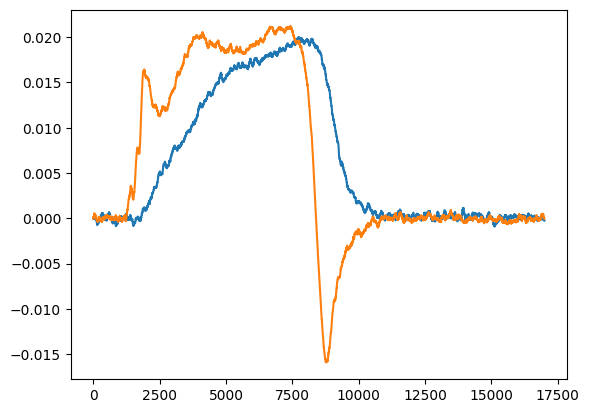

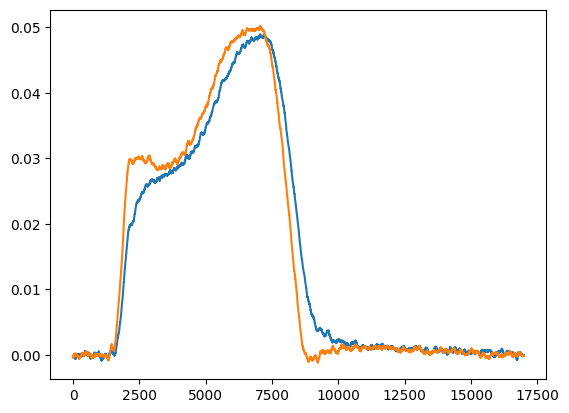

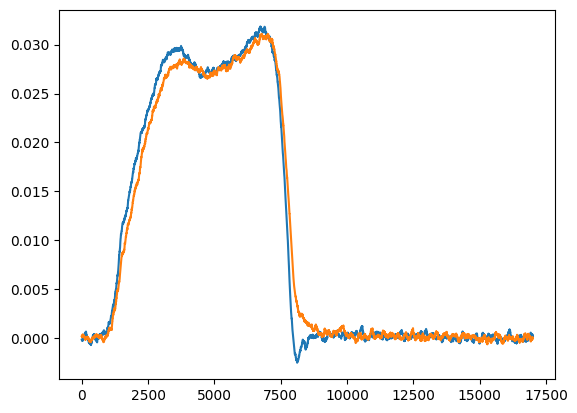

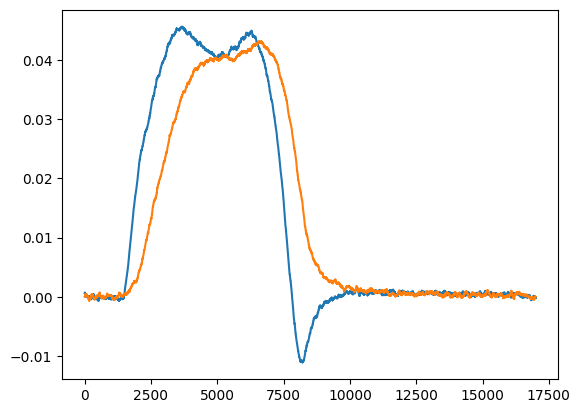

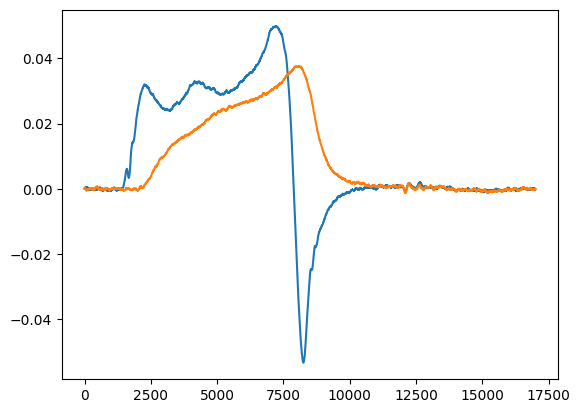

In [ ]:
# 6 generate test data using another data file

from scipy.signal import windows

df = pd.read_csv('/content/drive/MyDrive/Smart carpet/Testing Data/010401.csv',skiprows=6)
 # Extract data from the "AI0 (V)" and "AI1 (V)" columns
d1 = df["AI0 (V)"].values
d2 = df["AI1 (V)"].values
moving_avg_window = int(fs/100)
s1 = pd.Series(d1).rolling(window=moving_avg_window, min_periods=1, center=True).mean().values
s2 = pd.Series(d2).rolling(window=moving_avg_window, min_periods=1, center=True).mean().values
# Design the band-pass filter

b1, a1 = butter(order, low_cutoff_norm, btype='high', analog=False)
#filter_s1 = signal.lfilter(b, a, s1)
#filter_s2 = signal.lfilter(b, a, s2)

b2, a2 = butter(order, high_cutoff_norm, btype='low', analog=False)
#filter_s1 = signal.lfilter(b, a, filter_s1)
#filter_s2 = signal.lfilter(b, a, filter_s2)

reference_signal = s1
lagged_signal = s2

X_1 = np.zeros((0, sequence_length))
X_2 = np.zeros((0, sequence_length))
X_test_1= np.empty((0, sequence_length))
X_test_2 = np.empty((0,sequence_length))

i = int(sequence_length/20)

while i < len(reference_signal)-sequence_length:
      if reference_signal[i+1000] > reference_signal[i]+threshold or lagged_signal[i+1000] > lagged_signal[i]+threshold:
          start_idx = i - int(sequence_length/20)
          end_idx = start_idx + sequence_length
          t1 = reference_signal[start_idx:end_idx]
          t2 = lagged_signal[start_idx:end_idx]

          #calcualte average values at the beginning and end of the data
          average_a1 = np.mean(t1[:int(fs/20)])
          average_b1 = np.mean(t1[-int(fs/20):])
          average_a2 = np.mean(t2[:int(fs/20)])
          average_b2 = np.mean(t2[-int(fs/20):])
          # remove baseline
          for j in range(0, sequence_length, 1):
            t1[j]= t1[j]-((average_b1-average_a1)/float(sequence_length)*j+average_a1)
            t2[j]= t2[j]-((average_b2-average_a2)/float(sequence_length)*j+average_a2)

          plt.plot(t1)
          plt.plot(t2)

          #window = windows.hamming(len(t1)) # hamming window to reduce ripple
          #t1 = t1 * window
          #t2 = t2 * window
          #filter_s1 = signal.lfilter(b1, a1, t1)
          #filter_s2 = signal.lfilter(b1, a1, t2)
          #filter_s1 = signal.lfilter(b2, a2, filter_s1)
          #filter_s2 = signal.lfilter(b2, a2, filter_s2)
          #plt.plot(filter_s1)
          #plt.plot(filter_s2)
          plt.show()
          X_1 = t1[0:sequence_length][np.newaxis, :]  # Convert to 2D array
          X_2 = t2[0:sequence_length][np.newaxis, :]      # Convert to 2D array

          X_test_1 = np.append(X_test_1, X_1, axis=0)
          X_test_2 = np.append(X_test_2, X_2, axis=0)

          i += int(1.05*sequence_length)   # Move to the next possible rising area

      else:
          i += 1  # Continue searching for the next sharp rise

X_test = np.dstack((X_test_1, X_test_2))


In [ ]:
# 7 plot the assembled data points
num_samples, num_sampling_point = X_test_1.shape
# Create some sample data (replace this with your actual data)
# x = np.linspace(0, 10, num_samples)
# Loop through every two data points along the first index and plot X_lagged and X_reference
for sample_index in range(0, num_samples, 1):
    plt.figure()

    plt.plot(range(num_sampling_point), X_test_1[sample_index, :], label=f'X_test_1[{sample_index}, :]')
    plt.plot(range(num_sampling_point), X_test_2[sample_index, :], label=f'X_test_2[{sample_index}, :]')

    plt.title(f'Sample Index {sample_index + 1} Comparison')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()

# Show the plots
plt.show()


1/1 [==============================] - 0s 26ms/step


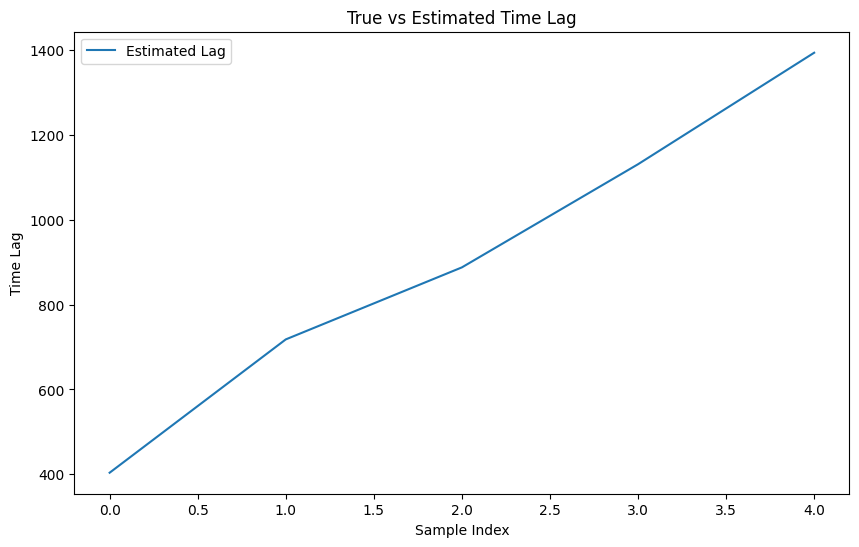

In [ ]:
# 7
estimated_lag = model.predict(X_test)
#estimated_lag = model.predict(x_valid)

# Plot true lag and estimated lag
plt.figure(figsize=(10, 6))
#plt.plot(y_valid, label='True Lag')
plt.plot(estimated_lag, label='Estimated Lag')
plt.xlabel('Sample Index')
plt.ylabel('Time Lag')
plt.legend()
plt.title('True vs Estimated Time Lag')
plt.show()

#abs_diff = np.abs(estimated_lag.T - y_valid.T)
# Calculate the meas absolute Error (MAE)
#mse = np.mean(abs_diff)
#print("Mean Absolute Error:", mse)

In [ ]:
plt.plot(cross_corr_features[10,:])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

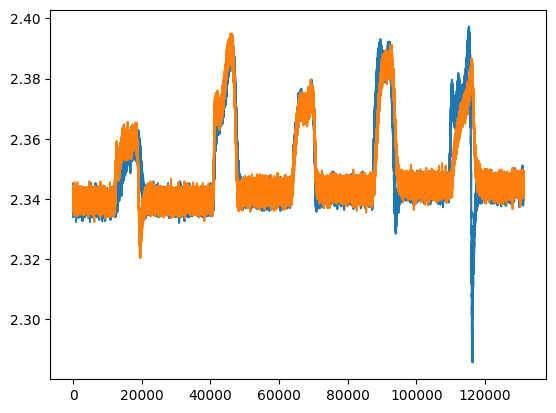

In [ ]:
plt.plot(d1)
plt.plot(d2)
#plt.ylim(-0.1,0.1)
plt.show